In [2]:
!pip install "python-doctr[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 6.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [32]:
!pip install pypdf2==1.26.0 reportlab==4.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pypdf2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61081 sha256=94e6616233c485262a37a6ae05882f9998d20047275e03654dadedb55da6f5c5
  Stored in directory: /Users/rohit/Library/Caches/pip/wheels/3a/62/ec/b6dea0b680005e9a961a3b195adb5f550b9586e92d20aed01d
Successfully built pypdf2
  Attempting uninstall: pypdf2
    Found existing installation: PyPDF2 3.0.1
    Uninstalling PyPDF2-3.0.1:
      Successfully uninstalled PyPDF2-3.0.1


In [1]:
# Imports
import base64
import re
from tempfile import TemporaryDirectory
from math import atan, cos, sin
from typing import Dict, Optional, Tuple
from xml.etree import ElementTree as ET
from xml.etree.ElementTree import Element

import numpy as np
import PyPDF2
from PyPDF2 import PdfFileMerger
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image
from reportlab.lib.colors import black
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen.canvas import Canvas

/Users/rohit/miniconda3/envs/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class HocrParser:

    def __init__(self):
        self.box_pattern = re.compile(r"bbox((\s+\d+){4})")
        self.baseline_pattern = re.compile(r"baseline((\s+[\d\.\-]+){2})")

    def _element_coordinates(self, element: Element) -> Dict:
        """
        Returns a tuple containing the coordinates of the bounding box around
        an element
        """
        out = out = {"x1": 0, "y1": 0, "x2": 0, "y2": 0}
        if "title" in element.attrib:
            matches = self.box_pattern.search(element.attrib["title"])
            if matches:
                coords = matches.group(1).split()
                out = {
                    "x1": int(coords[0]),
                    "y1": int(coords[1]),
                    "x2": int(coords[2]),
                    "y2": int(coords[3]),
                }
        return out

    def _get_baseline(self, element: Element) -> Tuple[float, float]:
        """
        Returns a tuple containing the baseline slope and intercept.
        """
        if "title" in element.attrib:
            matches = (
                self.baseline_pattern.search(element.attrib["title"]).group(1).split()
            )
            if matches:
                return float(matches[0]), float(matches[1])
        return (0.0, 0.0)

    def _pt_from_pixel(self, pxl: Dict, dpi: int) -> Dict:
        """
        Returns the quantity in PDF units (pt) given quantity in pixels
        """
        pt = [(c / dpi * inch) for c in pxl.values()]
        return {"x1": pt[0], "y1": pt[1], "x2": pt[2], "y2": pt[3]}

    def _get_element_text(self, element: Element) -> str:
        """
        Return the textual content of the element and its children
        """
        text = ""
        if element.text is not None:
            text += element.text
        for child in element:
            text += self._get_element_text(child)
        if element.tail is not None:
            text += element.tail
        return text

    def export_pdfa(
        self,
        out_filename: str,
        hocr: ET.ElementTree,
        image: Optional[np.ndarray] = None,
        fontname: str = "Times-Roman",
        fontsize: int = 12,
        invisible_text: bool = True,
        add_spaces: bool = True,
        dpi: int = 300,
    ):
        """
        Generates a PDF/A document from a hOCR document.
        """

        width, height = None, None
        # Get the image dimensions
        for div in hocr.findall(".//div[@class='ocr_page']"):
            coords = self._element_coordinates(div)
            pt_coords = self._pt_from_pixel(coords, dpi)
            width, height = (
                pt_coords["x2"] - pt_coords["x1"],
                pt_coords["y2"] - pt_coords["y1"],
            )
            # after catch break loop
            break
        if width is None or height is None:
            raise ValueError("Could not determine page size")

        pdf = Canvas(out_filename, pagesize=(width, height), pageCompression=1)

        span_elements = [element for element in hocr.iterfind(".//span")]
        for line in span_elements:
            if (
                "class" in line.attrib
                and line.attrib["class"] == "ocr_line"
                and line is not None
            ):
                # get information from xml
                pxl_line_coords = self._element_coordinates(line)
                line_box = self._pt_from_pixel(pxl_line_coords, dpi)

                # compute baseline
                slope, pxl_intercept = self._get_baseline(line)
                if abs(slope) < 0.005:
                    slope = 0.0
                angle = atan(slope)
                cos_a, sin_a = cos(angle), sin(angle)
                intercept = pxl_intercept / dpi * inch
                baseline_y2 = height - (line_box["y2"] + intercept)

                # configure options
                text = pdf.beginText()
                text.setFont(fontname, fontsize)
                pdf.setFillColor(black)
                if invisible_text:
                    text.setTextRenderMode(3)  # invisible text

                # transform overlayed text
                text.setTextTransform(
                    cos_a, -sin_a, sin_a, cos_a, line_box["x1"], baseline_y2
                )

                elements = line.findall(".//span[@class='ocrx_word']")
                for elem in elements:
                    elemtxt = self._get_element_text(elem).strip()
                    # replace unsupported characters
                    elemtxt = elemtxt.translate(
                        str.maketrans(
                            {"ﬀ": "ff", "ﬃ": "f‌f‌i", "ﬄ": "f‌f‌l", "ﬁ": "fi", "ﬂ": "fl"}
                        )
                    )
                    if not elemtxt:
                        continue

                    # compute string width
                    pxl_coords = self._element_coordinates(elem)
                    box = self._pt_from_pixel(pxl_coords, dpi)
                    if add_spaces:
                        elemtxt += " "
                        box_width = (
                            box["x2"]
                            + pdf.stringWidth(elemtxt, fontname, fontsize)
                            - box["x1"]
                        )
                    else:
                        box_width = box["x2"] - box["x1"]
                    font_width = pdf.stringWidth(elemtxt, fontname, fontsize)

                    # Adjust relative position of cursor
                    cursor = text.getStartOfLine()
                    dx = box["x1"] - cursor[0]
                    dy = baseline_y2 - cursor[1]
                    text.moveCursor(dx, dy)

                    # suppress text if it is 0 units wide
                    if font_width > 0:
                        text.setHorizScale(100 * box_width / font_width)
                        text.textOut(elemtxt)
                pdf.drawText(text)

        # overlay image if provided
        if image is not None:
            pdf.drawImage(
                ImageReader(Image.fromarray(image)), 0, 0, width=width, height=height
            )
        pdf.save()

In [3]:
import os

os.environ["USE_TORCH"] = "1"

In [4]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor("db_resnet50", "parseq", pretrained=True)

In [5]:
# PDF
doc = DocumentFile.from_pdf(
    "/Users/rohit/Desktop/code/bridge_test/Treadclimber manual.pdf"
)

In [6]:
result = model(doc)

In [7]:
img = result.pages[0].synthesize()


In [15]:
img.shape

(1224, 1008, 3)

In [19]:
from PIL import Image
import numpy as np

img = np.array(img, dtype=np.uint8)  # Ensure the data type is uint8

# Create an image object from the numpy array
image = Image.fromarray(img)

# Save the image
image.save("output.png")

In [20]:
image.show()

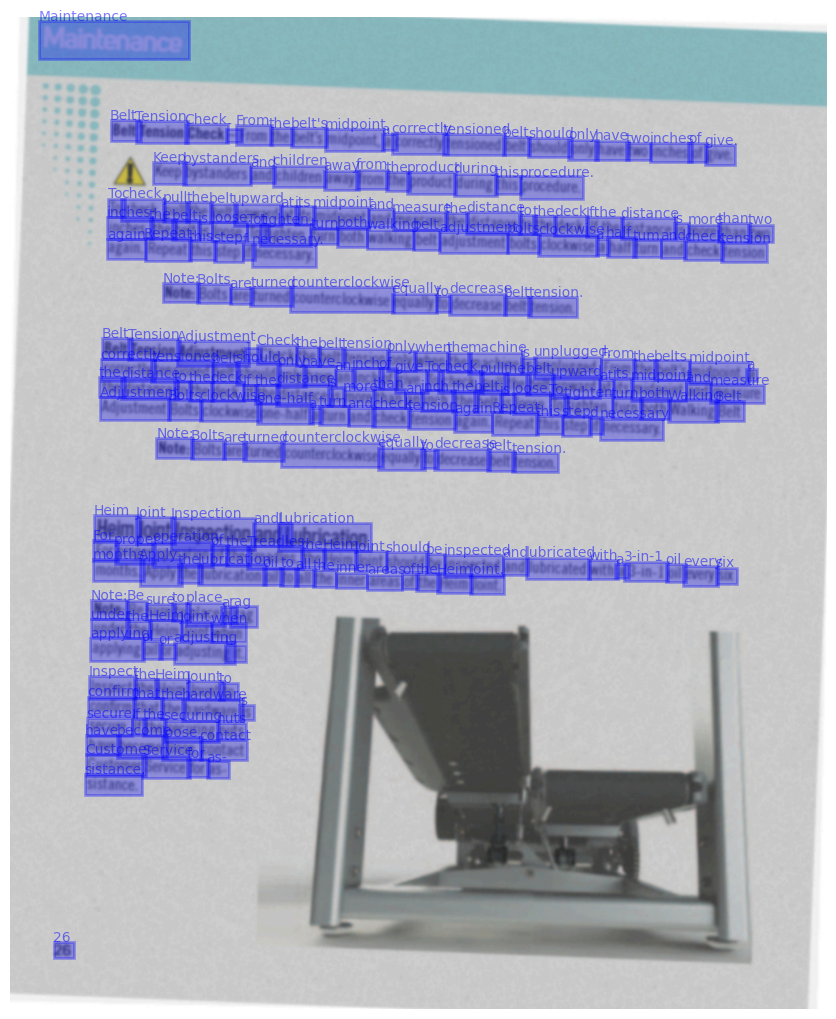

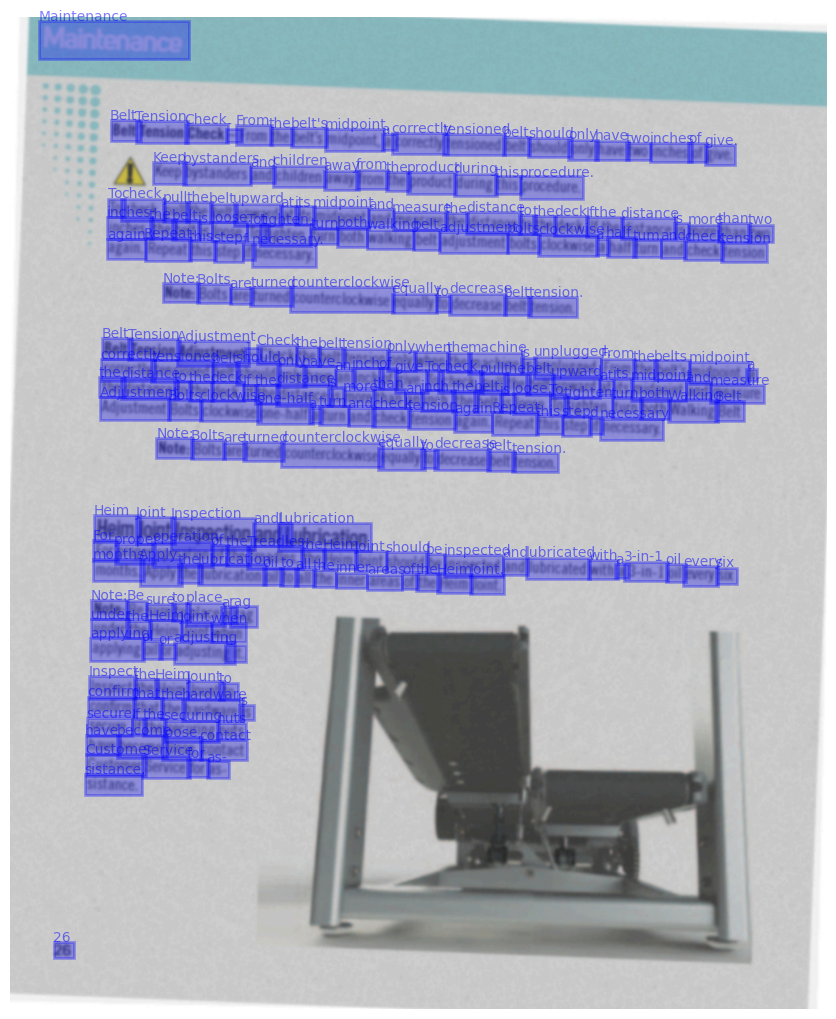

In [23]:
from doctr.utils.visualization import visualize_page

visualize_page(
    result.pages[0].export(), result.pages[0].page, interactive=False, add_labels=True
)

In [8]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# init the above parser
parser = HocrParser()

# you can also merge multiple pdfs into one

merger = PdfFileMerger()
for i, (xml, img) in enumerate(zip(xml_outputs, doc)):
    xml_element_tree = xml[1]
    with TemporaryDirectory() as tmpdir:
        parser.export_pdfa(f"{tmpdir}/{i}.pdf", hocr=xml_element_tree, image=img)
        merger.append(f"{tmpdir}/{i}.pdf")
merger.write(f"docTR-PDF.pdf")

In [12]:
# search specific words in the pdf and print all matches
pattern = "Allianz"
file_name = "docTR-PDF.pdf"

reader = PyPDF2.PdfFileReader(file_name)
num_pages = reader.getNumPages()

for i in range(0, num_pages):
    page = reader.getPage(i)
    print("page", i)

    text = page.extractText()
    print(text)

    # for match in re.finditer(pattern, text):
    #     print(f"Page no: {i} | Match: {match}")

page 0
Maintenance Belt Tension Check - From the belt's midpoint, a correctly tensioned belt should only have two inches of give. Keep bystanders and children away from the product during this procedure. To check, pull the belt upward at its midpoint and measure the distance to the inches, the belt is loose. Tot tighten, turn both walking belt deck Ifthe distance is more than two again. Repeat this step f necessary. adjustment bolts clockwise a half tum and check tension Note: Bolts are turned counterclockwise equally to decrease belt tension. Belt Tension Adjustment - Check the belt tension only when the machine is correctly tensioned belt should only have an inch of give. To the distance to the deck If the distance is more than unplugged. From the belts midpoint, a check, pull the belt upward at its midpoint and measure Adjustment Bolts clockwise an inch, the belt is loose. To tighten, turn both one-half a turn and check tension again. Repeat this step d Walking Belt necessary Note: 

In [11]:
# search specific words in the pdf and print all matches
pattern = "Allianz"
file_name = "/Users/rohit/Desktop/code/bridge_test/Treadclimber manual.pdf"

reader = PyPDF2.PdfFileReader(file_name)
num_pages = reader.getNumPages()

for i in range(0, num_pages):
    page = reader.getPage(i)
    print("page", i)
    text = page.extractText()
    print(text)

    # for match in re.finditer(pattern, text):
    #     print(f"Page no: {i} | Match: {match}")

page 0

page 1

page 2

page 3

page 4

page 5

page 6

page 7

